In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from tqdm import tqdm #進度條

import warnings
warnings.filterwarnings('ignore')

In [2]:
#讀取檔案路徑
datadir='//data/examples/may_the_4_be_with_u/where_am_i/'

#labelmap
labelmap = pd.read_csv(datadir+'mid_term_mapping.txt',names=['place','index'])

In [3]:
labelmap.sort_values('index')

,place,index
8,kitchen,0
13,street,1
6,industrial,2
7,insidecity,3
4,forest,4
9,livingroom,5
11,opencountry,6
1,PARoffice,7
10,mountain,8
0,CALsuburb,9


In [4]:
#將labelmap以index排序後傳出成targetlist
sortlabel=labelmap.sort_values('index')
targetlist=sortlabel.place.as_matrix().tolist()
targetlist

['kitchen',
 'street',
 'industrial',
 'insidecity',
 'forest',
 'livingroom',
 'opencountry',
 'PARoffice',
 'mountain',
 'CALsuburb',
 'coast',
 'store',
 'bedroom',
 'tallbuilding',
 'highway']

## Red image & Label One Hot encoding
### Keras imagedatagenerator

In [5]:
import cv2 #image
import glob #文件路徑

sz = 256

x=[]
y=[]
for i,c in enumerate(targetlist): #列出數據和數據下標
    ff=glob.glob((datadir+'train/'+c+'/*jpg')) #讀取train底下的資料夾路徑
    for f in ff:
        img=cv2.imread(f,0) #灰階模式讀入圖
        img200=cv2.resize(img,(sz,sz)) #所有圖片大小統一
        iii=(np.reshape(img200,(sz,sz,1))).astype(float) #三維數據 
        x.append(iii)
        
        ## one-hot encoding
        nn=np.zeros(15,dtype=float) #zero()返回一個給定形狀和類型的用0填充的數組
        nn[i]=1
        ##        
        y.append(nn)
        
xx=np.array(x) #image
yy=np.array(y) #target

In [6]:
print(xx.shape)
print(yy.shape)
print(xx[0,[3]].shape)

(2985, 256, 256, 1)
(2985, 15)
(1, 256, 1)


In [7]:
from  keras.preprocessing.image  import ImageDataGenerator

datagen = ImageDataGenerator(       width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
gen_data = datagen.flow(xx,yy,batch_size= len(x))

gen = 10
for i in tqdm(range(gen)):
    data = gen_data.next()
    xx = np.concatenate((xx,data[0]))
    yy = np.concatenate((yy,data[1]))

Using TensorFlow backend.
100%|██████████| 10/10 [01:46<00:00, 10.66s/it]


In [8]:
print(xx.shape)
print(yy.shape)
print(xx[0,[3]].shape)

(32835, 256, 256, 1)
(32835, 15)
(1, 256, 1)


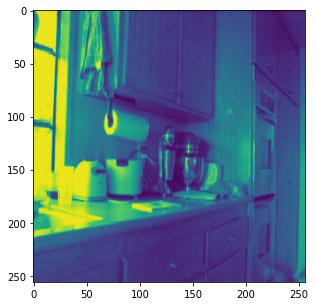

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(xx[0,:,:,0])
plt.show()

stratify：array-like或者None，默認是None。。

若為None時，劃分出來的測試集或訓練集中，其類標籤的比例也是隨機的。

若不為None時，劃分出來的測試集或訓練集中，其類標籤的比例同輸入的數組中類標籤的比例相同，可以用於處理不均衡的數據集。
sklearn.model_selection.train_test_split

In [10]:
#----------------------------資料training set, testing set 分割---------------------------------------
from sklearn.model_selection import train_test_split #資料分割
#stratify如果不是None，將會利用數據的標籤將數據分層劃分
x_train, x_valid, y_train, y_valid = train_test_split(xx,yy,test_size = 0.3,stratify = yy.argmax(axis = 1))
#------------------------------------檢查資料---------------------------------------------------------
print("training set data dimension")
print(x_train.shape)
print(y_train.shape)
print("-----------")
print("training set: %i" % len(x_train))
print("validation set: %i" % len(x_valid))

training set data dimension
(22984, 256, 256, 1)
(22984, 15)
-----------
training set: 22984
validation set: 9851


## Batch & Normalize

In [11]:
from sklearn.utils import shuffle

def train_batch_generater(x ,y , bs):
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind,0) #take() 其旨在根據提供的索引值將元素形成數組輸出
        y = y.take(new_ind,0)
        
        total_batch = int(len(x)/bs)
        
        for i in range(total_batch):
            batch_idx_start = i * bs
            batch_idx_stop = (i+1) * bs
            
            x_batch = x[batch_idx_start : batch_idx_stop]
            y_batch = y[batch_idx_start : batch_idx_stop]
            
            x_batch /= 255. #歸一化
            
            yield x_batch,y_batch   

# create graph

In [12]:
import tensorflow as tf

tf.reset_default_graph() #重新 build graph   

## Step 1 : define placeholder

In [13]:
def neural_net_image_input(image_shape):
    image = tf.placeholder(dtype = tf.float32,
                           shape = [None,image_shape[0],image_shape[1],image_shape[2]],
                           name = 'x')
    return image

def neural_net_label_input(n_classes):
    label = tf.placeholder(dtype = tf.float32,
                           shape = [None, n_classes],
                           name = 'y')
    return label
    
#dropout retaining probability
def neural_net_keep_prob_input():
    keep_prob = tf.placeholder(dtype= tf.float32,
                               name = 'keep_prob')
    return keep_prob

In [14]:
#input_data = tf.placeholder(dtype = tf.float32,
#                            shape = [None,(x_train.shape[1]*x_train.shape[2])],###65536
#                            name  = 'input_data')
#y_true     = tf.placeholder(dtype = tf.float32,
#                            shape = [None,y_train.shape[1]],#15
#                            name  = 'y_true')


### Convolution amd Max Pooling Layer

In [15]:
##convolution + Relu
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides): 
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """    
    conv_layer = tf.layers.conv2d(x_tensor, conv_num_outputs, kernel_size=conv_ksize, strides=conv_strides, activation=tf.nn.relu, padding="same")
    #conv_layer = tf.layers.max_pooling2d(conv_layer, pool_size=pool_ksize, strides= pool_strides)
    
    return conv_layer

In [16]:
##Max pooling
def maxpool(conv_layer, pool_ksize, pool_strides):
    maxpool_layer = tf.layers.max_pooling2d(conv_layer, pool_size=pool_ksize, strides= pool_strides)
    
    return maxpool_layer

### Flatten Layer

In [17]:
def flatten(x_tensor):
    return tf.layers.flatten(x_tensor)

### Fully-Connected Layer
    dense layer

In [18]:
##fully connected + Relu
def fully_conn(x_tensor, num_outputs):
    return tf.layers.dense(x_tensor, num_outputs, activation = tf.nn.relu)

### Output Layer
    output Layer 只是要將 layer 的結果 output 出來，不需要加上任何的 activation layer

In [19]:
def output(x_tensor, num_outputs):
    return tf.layers.dense(x_tensor, num_outputs, activation = None)

### Create Convolutional Model

Keras參考
https://blog.csdn.net/cai13160674275/article/details/71078554

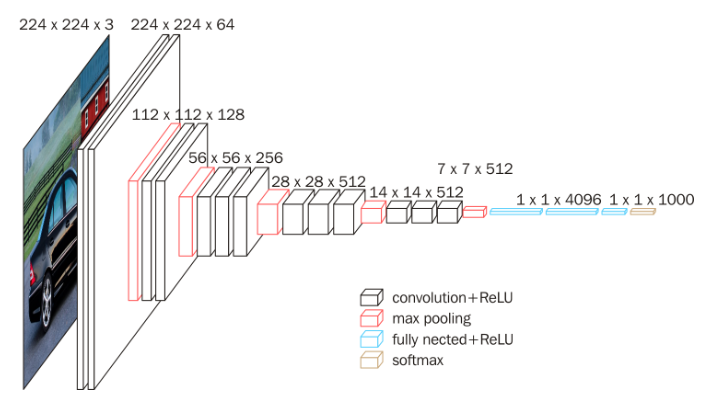

In [20]:
from IPython.display import Image
Image(filename='2018-07-19_171147.png')

In [21]:
#參考VGG16
def conv_net_VGG16(x, keep_prob):
    # Create a convolutional neural network Model
    
    #參數
    conv_ksize = (3,3)
    conv_strides = (1,1)
    pool_ksize = (2,2)
    pool_strides = (2,2)
    n_filters_1 = 64
    n_filters_2 = 128
    n_filters_3 = 256
    n_filters_4 = 512
    
    #Convolution and Max Pool layers
    conv_1 = conv2d(x, n_filters_1, conv_ksize, conv_strides) #256*256*64
    conv_2 = conv2d(conv_1, n_filters_1, conv_ksize, conv_strides)
    
    conv_3 = maxpool(conv_2, pool_ksize, pool_strides) #128*128*64
    conv_4 = conv2d(conv_3, n_filters_2, conv_ksize, conv_strides) #128*128*128
    conv_5 = conv2d(conv_4, n_filters_2, conv_ksize, conv_strides)
    
    conv_6 = maxpool(conv_5, pool_ksize, pool_strides) #64*64*128
    conv_7 = conv2d(conv_6, n_filters_3, conv_ksize, conv_strides) #64*64*256
    conv_8 = conv2d(conv_7, n_filters_3, conv_ksize, conv_strides)
    conv_9 = conv2d(conv_8, n_filters_3, conv_ksize, conv_strides)
    
    conv_10 = maxpool(conv_9, pool_ksize, pool_strides) #32*32*256
    conv_11 = conv2d(conv_10, n_filters_4, conv_ksize, conv_strides) #32*32*512
    conv_12 = conv2d(conv_11, n_filters_4, conv_ksize, conv_strides)
    conv_13 = conv2d(conv_12, n_filters_4, conv_ksize, conv_strides)
    
    conv_14 = maxpool(conv_13, pool_ksize, pool_strides) #16*16**512
    conv_15 = conv2d(conv_14, n_filters_4, conv_ksize, conv_strides) #16*16*512
    conv_16 = conv2d(conv_15, n_filters_4, conv_ksize, conv_strides)
    conv_17 = conv2d(conv_16, n_filters_4, conv_ksize, conv_strides)
    
    conv_18 = maxpool(conv_17, pool_ksize, pool_strides) #8*8*512
    
    #Flatten Layer
    fc = flatten(conv_18) #32768
    
    #Fully Connected Layers + droput
    fc1 = fully_conn(fc, 4096)
    fc2 = tf.nn.dropout(fc1, keep_prob= keep_prob)
    
    fc3 = fully_conn(fc2, 4096)
    fc4 = tf.nn.dropout(fc3, keep_prob= keep_prob)
    
    fc5 = fully_conn(fc4, 1000)
    
    #Out put Layer     
    out = output(fc2, 15)
    
    return out
       

#### Build the Neural Network

In [22]:
#初始化 graph
tf.reset_default_graph()

#Input
x = neural_net_image_input((sz,sz,1))
y = neural_net_label_input(y_train.shape[1])
keep_prob = neural_net_keep_prob_input()

#Model 的output (還沒有經過 softmax function，這些 output 的值通常為 logits)
logits = conv_net_VGG16(x, keep_prob)

#Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name = 'logits')

#Loss and Opermizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

lr = 0.01
opt = tf.train.AdamOptimizer(learning_rate=lr)
update = opt.minimize(loss)

#Accuracy
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name= 'accuracy')

## Train the Neural Network

In [23]:
def train_neural_network(session, update, keep_probability, feature_batch, label_batch):
    session.run(update, feed_dict= {x:feature_batch,y:label_batch,keep_prob: keep_probability})

### Show Status

In [24]:
def status(session, feature_batch, label_batch):
    train_loss_batch = session.run(loss, feed_dict= {x:feature_batch,y:label_batch,keep_prob: 1.})
    train_acc_batch = session.run(accuracy, feed_dict= {x:feature_batch,y:label_batch,keep_prob: 1.})
    
    return train_loss_batch,train_acc_batch

In [25]:
tf.global_variables() 

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'conv2d_3/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'conv2d_4/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv2d_5/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv2d_5/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv2d_6/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv2d_6/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'con

# run session

## step 1 : run global variables initialization

In [26]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

## step 2 : run optimizer

In [27]:
from sklearn.metrics import accuracy_score

#訓練參數
epoch = 30 #更新30次
bs = 8 #每次32筆
update_per_epoch = 100 #1個epoch更新100次
keep_probability = 0.5

tr_loss = list() #紀錄training Loss
tr_acc = list() #紀錄 training Accuracy

train_gen = train_batch_generater(x_train,y_train,bs)
valid_gen = train_batch_generater(x_valid,y_valid,bs)

## Train on a Single Batch

In [28]:
#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    x_batch, y_batch = next(train_gen)
    
#    for i in range(epoch):
#        train_neural_network(sess, update, keep_probability, x_batch, y_batch)
#        train_loss_batch,
#        print('Epoch {:>2},Batch{}: '.format(i + 1, 1),end='')
#        print_status(sess,x_batch,y_batch,loss,accuracy)

In [ ]:
"""
from  keras.preprocessing.image  import ImageDataGenerator

datagen = ImageDataGenerator(       width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
gen_data = datagen.flow(xx,yy,batch_size= len(x))

data = gen_data.next() 

xx = np.concatenate((xx,data[0]))
yy = np.concatenate((yy,data[1]))
"""

'\nfrom  keras.preprocessing.image  import ImageDataGenerator\n\ndatagen = ImageDataGenerator(       width_shift_range=0.2,\n                                    height_shift_range=0.2,\n                                    shear_range=0.2,\n                                    zoom_range=0.2,\n                                    horizontal_flip=True)\ngen_data = datagen.flow(xx,yy,batch_size= len(x))\n\ndata = gen_data.next() \n\nxx = np.concatenate((xx,data[0]))\nyy = np.concatenate((yy,data[1]))\n'

## Sess run

In [ ]:
sess.run(tf.global_variables_initializer()) #開始前先初始化

for i in range(epoch):
    
    #calculate training loss & update variables
    training_loss = 0
    training_acc = 0
    
    for j in tqdm(range(update_per_epoch)): 
        
        x_batch, y_batch = next(train_gen)
        train_neural_network(sess, update, keep_probability, x_batch, y_batch)
        
        train_loss_batch,train_acc_batch = status(sess, x_batch, y_batch)
        
        training_loss += train_loss_batch
        training_acc += train_acc_batch
    
    training_loss /= update_per_epoch
    training_acc /= update_per_epoch
    
    tr_loss.append(training_loss)
    tr_acc.append(training_acc)
        
    print('epoch {epochs}: training loss: {training_loss} ； training acc: {training_acc}'.format(epochs = (i+1),training_loss= training_loss,training_acc= training_acc))
    

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1: training loss: 250646202.21941912 ； training acc: 0.1075


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 2: training loss: 2.6686754393577576 ； training acc: 0.1075


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 3: training loss: 2.6747085070610046 ； training acc: 0.08625


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 4: training loss: 2.663603308200836 ； training acc: 0.09375


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 5: training loss: 2.6645505833625793 ； training acc: 0.115


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 6: training loss: 2.6744788599014284 ； training acc: 0.10625


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 7: training loss: 2.676570649147034 ； training acc: 0.08125


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 8: training loss: 2.6628925085067747 ； training acc: 0.0975


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 9: training loss: 2.674492988586426 ； training acc: 0.10375


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 10: training loss: 2.6709522867202757 ； training acc: 0.09


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 11: training loss: 2.657571301460266 ； training acc: 0.0975


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 12: training loss: 2.654260630607605 ； training acc: 0.10875


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 13: training loss: 2.6428034329414367 ； training acc: 0.1375


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 14: training loss: 2.6712965106964113 ； training acc: 0.0975


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 15: training loss: 2.6748537397384644 ； training acc: 0.11625


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 16: training loss: 2.647905743122101 ； training acc: 0.09625


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 17: training loss: 2.647370195388794 ； training acc: 0.10625


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 18: training loss: 2.658843014240265 ； training acc: 0.12375


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 19: training loss: 2.6614507913589476 ； training acc: 0.10875


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 20: training loss: 2.6642586374282837 ； training acc: 0.0975


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 21: training loss: 2.6726031374931334 ； training acc: 0.09125


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 22: training loss: 2.6780487942695617 ； training acc: 0.0975


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 23: training loss: 2.6623933148384094 ； training acc: 0.095


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 24: training loss: 2.665309693813324 ； training acc: 0.10375


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 25: training loss: 2.667023031711578 ； training acc: 0.08375


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 26: training loss: 2.6746987748146056 ； training acc: 0.0825


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 27: training loss: 2.672783148288727 ； training acc: 0.10375


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 28: training loss: 2.6522378087043763 ； training acc: 0.0975


 73%|███████▎  | 73/100 [00:14<00:05,  4.88it/s]

### Valid 資料帶入預測

In [ ]:
for i in tqdm(range(1))

In [ ]:
for i in range(epoch):
    
    #calculate training loss & update variables
    training_loss = 0
    training_acc = 0

    for j in tqdm(range(update_per_epoch)): 
        
        x_batch, y_batch = next(train_gen) ##
        
        #"_"python:一個臨時性名稱使用；分配一個名稱，但在後面不會用到
        tr_pred, train_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={input_data:x_batch,y_true:y_batch})
        
        training_loss += train_loss_batch 
        
        #training Accuracy
        training_acc_batch = accuracy_score(np.argmax(y_batch,axis= 1),np.argmax(tr_pred,axis= 1))
        training_acc += training_acc_batch           
    
    #算平均
    training_loss /= update_per_epoch
    training_acc /= update_per_epoch
    
    tr_loss.append(training_loss)
    tr_acc.append(training_acc)
    
    print('epoch {epochs}: training loss{training_loss}'.format(epochs = (i+1),training_loss= training_acc))

## polt model training result

In [ ]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(tr_loss)),tr_loss,label = 'training')
plt.title('Loss')
plt.legend(loc = 'best')
plt.subplot(122)
plt.plot(range(len(tr_acc)),tr_acc,label = 'training')
plt.title('Accuracy')
plt.show()

## 以測試資料評估模型準確率與預測

### Step1. 模型準確率

In [24]:
print('epoch {epochs}: training acc{training_acc}'.format(epochs = (i+1),training_acc= training_acc))

epoch 30: training acc0.1028125
